In [2]:
import pandas as pd
import glob
import os
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import  Dropout
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
import lightgbm as lgb
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv(r"C:\Users\attafuro\Desktop\EV Charging Analysis\cleaned_traffic_data.csv")

In [5]:
# Define the final selected columns
selected_columns = [
    "Timestamp", "Station", "Route", "Direction of Travel",
    "Total Flow", "Avg Speed", "% Observed","Samples","Lane Type"
]

# Keep only the selected columns
df = df[selected_columns]

In [6]:
df.drop(columns=["Avg Speed"], inplace=True)

In [7]:
df = df[df['Total Flow'].notna()]

In [8]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)
df.sort_index(inplace=True)

In [9]:
# Convert Station to categorical type
df['Station'] = df['Station'].astype('category')

In [10]:
df['Hour'] = df.index.hour
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday
df['IsWeekend'] = df['Weekday'].isin([5, 6]).astype(int)

In [11]:
for lag in range(1, 73):  # Lags 1 to 72
    df[f'TotalFlow_lag_{lag}'] = df['Total Flow'].shift(lag)

# Drop the rows that now have NaNs in these lag features (first 72 rows)
df.dropna(inplace=True)

In [12]:
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
df['Weekday_sin'] = np.sin(2 * np.pi * df['Weekday'] / 7)
df['Weekday_cos'] = np.cos(2 * np.pi * df['Weekday'] / 7)

In [13]:
for window in [3, 6, 12, 24, 48, 72]:
    df[f'Flow_mean_{window}'] = df['Total Flow'].rolling(window=window).mean()
    df[f'Flow_std_{window}'] = df['Total Flow'].rolling(window=window).std()
    df[f'Flow_min_{window}'] = df['Total Flow'].rolling(window=window).min()
    df[f'Flow_max_{window}'] = df['Total Flow'].rolling(window=window).max()

In [14]:
df.dropna(inplace=True)

In [15]:
custom_holidays = [
    pd.to_datetime("2024-12-25"),
    pd.to_datetime("2024-12-31"),
    pd.to_datetime("2024-11-24"),
]
df['IsHoliday'] = df.index.to_series().apply(lambda x: 1 if x in custom_holidays else 0)

In [16]:
for window in [12, 24, 48, 72]:
    df[f'Flow_CV_{window}'] = df[f'Flow_std_{window}'] / df[f'Flow_mean_{window}']

In [17]:
# Group by station and calculate mean and std of Total Flow
station_stats = df.groupby('Station')['Total Flow'].agg(['mean', 'std'])
station_stats['CV'] = station_stats['std'] / station_stats['mean']
station_stats.dropna(inplace=True)  

In [18]:
df.dropna(inplace=True)

In [19]:
cat_features = [
    'Station', 'Route', 'Direction of Travel', 'Lane Type',
    'Weekday', 'IsWeekend', 'IsHoliday'
]

for col in cat_features:
    df[col] = df[col].astype('category')

In [20]:
# --- Your base groups stay as-is ---
flow_features = [
    'Flow_mean_3', 'Flow_std_3', 'Flow_max_3', 'Flow_min_3',
    'Flow_mean_72', 'Flow_std_72', 'Flow_std_48', 'Flow_max_24',
    'Flow_mean_24', 'Flow_mean_48', 'Flow_CV_48'
]

lag_features = [
    'TotalFlow_lag_1', 'TotalFlow_lag_2', 'TotalFlow_lag_3',
    'TotalFlow_lag_7', 'TotalFlow_lag_8', 'TotalFlow_lag_15', 'TotalFlow_lag_18'
]

time_features = ['Hour', 'Hour_cos', 'Hour_sin', 'Weekday_cos']
quality_features = ['Samples', '% Observed']

# --- Copy and encode ---
df_model = df.copy()

# 1) Holiday as numeric 0/1 (simple and robust)
df_model['IsHoliday'] = df_model['IsHoliday'].astype(int)

# 2) One-hot Direction of Travel with a FIXED level set
dir_levels = ['E','N','S','W']  # full set
df_model['Direction of Travel'] = (
    df_model['Direction of Travel'].astype('category').cat.set_categories(dir_levels)
)
dir_dummies = pd.get_dummies(df_model['Direction of Travel'],
                             prefix='Dir', drop_first=False)

# Attach and drop original cat
df_model = pd.concat([df_model.drop(columns=['Direction of Travel']), dir_dummies], axis=1)

# 3) FINAL FEATURE LIST (per-station model): DO NOT include Station, Route, Lane Type
selected_features = (
    flow_features
    + lag_features
    + time_features
    + quality_features
    + ['IsHoliday']                # numeric
    + list(dir_dummies.columns)    # one-hot: Dir_E, Dir_N, Dir_S, Dir_W
)

# Sanity checks
missing = [c for c in selected_features if c not in df_model.columns]
if missing:
    raise KeyError(f"Missing features in df_model: {missing}")

non_num = [c for c in selected_features if not pd.api.types.is_numeric_dtype(df_model[c])]
if non_num:
    raise TypeError(f"Non-numeric features in selected_features: {non_num}")


## Conference Work on LSTM 

In [21]:
# ==== GLOBAL MODEL (single model for all stations) — 72h, leakage-safe ====

import os, logging, time, warnings, gc
import numpy as np, pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf

# Quiet TensorFlow logs (optional)
tf.get_logger().setLevel(logging.ERROR)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings("ignore", category=RuntimeWarning)

# ----- constants -----
HORIZON     = 72
LOOKBACK    = 24
TRAIN_R     = 0.70
VAL_R       = 0.15
EPOCHS      = 25
BATCH_TRAIN = 256
BATCH_PRED  = 512
EMB_DIM     = 16  # station embedding size

# Base flow + hygiene
BASE_FLOW = 'TotalFlow' if 'TotalFlow' in df_model.columns else 'Total Flow'
df_model['Samples']    = pd.to_numeric(df_model['Samples'], errors='coerce')
df_model['% Observed'] = pd.to_numeric(df_model['% Observed'], errors='coerce')

# -------- Feature engineering per-station (no cross-station leakage) --------
g = df_model.groupby('Station', group_keys=False)

# Long lags helpful for 72h
for lag in [72, 168]:
    col = f'{BASE_FLOW}_lag_{lag}'
    if col not in df_model.columns:
        df_model[col] = g[BASE_FLOW].shift(lag)
    if col not in selected_features: selected_features.append(col)

# Weekly rolling context from strictly past data
if 'Flow_mean_168' not in df_model.columns:
    df_model['Flow_mean_168'] = g[BASE_FLOW].shift(1).rolling(168, min_periods=24).mean()
if 'Flow_std_168' not in df_model.columns:
    df_model['Flow_std_168']  = g[BASE_FLOW].shift(1).rolling(168, min_periods=24).std()
for c in ['Flow_mean_168','Flow_std_168']:
    if c not in selected_features: selected_features.append(c)

# -------- TIME-BASED TARGET (works even with missing hours) --------
dfg = df_model.copy()
dfg['ts_anchor']   = dfg.index
dfg['ts_forecast'] = dfg.index + pd.Timedelta(hours=HORIZON)

future = df_model[['Station', BASE_FLOW]].rename(columns={BASE_FLOW:'y_72'}).copy()
future['ts_forecast'] = future.index

dfg = dfg.merge(future[['Station','ts_forecast','y_72']],
                on=['Station','ts_forecast'], how='left')

# Keep only rows with future value + all features
dfg = dfg.dropna(subset=list(set(selected_features + ['y_72']))).sort_index()

# -------- Station index for embedding --------
station_ids = sorted(dfg['Station'].unique().tolist())
sid2idx = {sid:i for i, sid in enumerate(station_ids)}
idx2sid = np.array(station_ids)
dfg['station_idx'] = dfg['Station'].map(sid2idx).astype('int32')
N_STATIONS = len(station_ids)

# -------- Build sequences per station, scale X on TRAIN slice only --------
def make_sequences(df_station, feature_cols, lookback):
    vals  = df_station[feature_cols + ['y_72']].to_numpy(dtype=np.float32)
    tsall = df_station['ts_forecast'].to_numpy()
    stidx = df_station['station_idx'].iloc[0]
    X, y, ts, sidx = [], [], [], []
    for i in range(lookback, len(vals)):
        X.append(vals[i-lookback:i, :len(feature_cols)])
        y.append(vals[i, -1])
        ts.append(tsall[i])
        sidx.append(stidx)
    return np.array(X, np.float32), np.array(y, np.float32), np.array(ts), np.array(sidx, dtype='int32')

X_list_tr, y_list_tr, ts_list_tr, sidx_list_tr = [], [], [], []
X_list_v , y_list_v , ts_list_v , sidx_list_v  = [], [], [], []
X_list_te, y_list_te, ts_list_te, sidx_list_te = [], [], [], []

for sid in station_ids:
    sdf = dfg[dfg['Station']==sid].copy().sort_index()
    if len(sdf) < LOOKBACK + 200:   # require enough history
        continue

    # Fit X-scaler on TRAIN slice only
    n_total = len(sdf); n_train_rows = int(n_total * TRAIN_R)
    x_scaler = StandardScaler().fit(sdf.iloc[:n_train_rows][selected_features])
    sdf.loc[:, selected_features] = x_scaler.transform(sdf[selected_features])

    # Sequences
    X, y, ts, sidx = make_sequences(sdf, selected_features, LOOKBACK)
    if len(X) < 100:  # guard
        continue

    # Chronological split inside this station
    n = len(X); nt = int(n*TRAIN_R); nv = int(n*(TRAIN_R+VAL_R))
    Xtr, ytr, ttr, s_tr = X[:nt], y[:nt], ts[:nt], sidx[:nt]
    Xv , yv , tv , s_v  = X[nt:nv], y[nt:nv], ts[nt:nv], sidx[nt:nv]
    Xte, yte, tte, s_te = X[nv:], y[nv:], ts[nv:], sidx[nv:]

    # Append to global lists
    X_list_tr.append(Xtr); y_list_tr.append(ytr); ts_list_tr.append(ttr); sidx_list_tr.append(s_tr)
    X_list_v .append(Xv ); y_list_v .append(yv ); ts_list_v .append(tv ); sidx_list_v .append(s_v )
    X_list_te.append(Xte); y_list_te.append(yte); ts_list_te.append(tte); sidx_list_te.append(s_te)

# Concatenate across stations
def cat(lst): 
    return np.concatenate(lst, axis=0) if lst else np.empty((0,), dtype=np.float32)

Xtr = cat(X_list_tr); ytr = cat(y_list_tr); ttr = cat(ts_list_tr); s_tr = np.concatenate(sidx_list_tr) if sidx_list_tr else np.array([], dtype='int32')
Xv  = cat(X_list_v ); yv  = cat(y_list_v ); tv  = cat(ts_list_v ); s_v  = np.concatenate(sidx_list_v ) if sidx_list_v  else np.array([], dtype='int32')
Xte = cat(X_list_te); yte = cat(y_list_te); tte = cat(ts_list_te); s_te = np.concatenate(sidx_list_te) if sidx_list_te else np.array([], dtype='int32')

print(f"Samples — train:{len(Xtr)}  val:{len(Xv)}  test:{len(Xte)}")

# Scale TARGET on TRAIN only (global, train-only → no leakage)
y_scaler = StandardScaler().fit(ytr.reshape(-1,1))
ytr_s = y_scaler.transform(ytr.reshape(-1,1)).ravel()
yv_s  = y_scaler.transform(yv.reshape(-1,1)).ravel()

# -------- Build global model: sequence input + station embedding --------
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

seq_in = Input(shape=(LOOKBACK, Xtr.shape[2]), name='seq_in')
st_in  = Input(shape=(), dtype='int32', name='station_in')

emb = Embedding(input_dim=N_STATIONS, output_dim=EMB_DIM, name='station_emb')(st_in)  # (batch, EMB_DIM)
x   = LSTM(128)(seq_in)
x   = Concatenate()([x, emb])
x   = Dense(64, activation='relu')(x)
out = Dense(1)(x)

model = Model(inputs=[seq_in, st_in], outputs=out)
model.compile(optimizer=Adam(learning_rate=3e-4, clipnorm=1.0), loss=Huber(delta=1.0))
model.summary()

# Warm-up to stabilize TF graph
_ = model.predict([np.zeros((1, LOOKBACK, Xtr.shape[2]), dtype=np.float32),
                   np.zeros((1,), dtype='int32')], batch_size=1, verbose=0)

# Train
es = EarlyStopping(monitor='val_loss', patience=5, min_delta=1e-3, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, min_lr=1e-5, verbose=1)

history = model.fit([Xtr, s_tr], ytr_s,
                    validation_data=([Xv, s_v], yv_s),
                    epochs=EPOCHS, batch_size=BATCH_TRAIN,
                    verbose=1, shuffle=True,  # OK to shuffle samples across stations
                    callbacks=[es, rl])

# Predict on test, inverse-transform target
yhat_s = model.predict([Xte, s_te], batch_size=BATCH_PRED, verbose=0).ravel()
yhat   = y_scaler.inverse_transform(yhat_s.reshape(-1,1)).ravel()

# Assemble predictions dataframe
stations_te = idx2sid[s_te]  # map indices back to station IDs
preds_72h = pd.DataFrame({
    'Station': stations_te,
    'ts_forecast': tte,
    'actual_72h': yte,
    'pred_72h': yhat
}).sort_values(['Station','ts_forecast'])
preds_72h['residual'] = preds_72h['actual_72h'] - preds_72h['pred_72h']

# Metrics per station
def agg_metrics(df):
    return pd.Series({
        'MAE_72h': mean_absolute_error(df['actual_72h'], df['pred_72h']),
        'RMSE_72h': mean_squared_error(df['actual_72h'], df['pred_72h'], squared=False)
    })

metrics_72h = preds_72h.groupby('Station', as_index=False).apply(agg_metrics)

# Save
preds_72h.to_csv('predictions_72h_by_station.csv', index=False)
metrics_72h.to_csv('metrics_72h_by_station.csv', index=False)
print("Saved predictions_72h_by_station.csv and metrics_72h_by_station.csv")


Samples — train:2313853  val:496395  test:496869


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer)           │ (None, 24, 33)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ station_in (InputLayer)       │ (None)                    │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ lstm (LSTM)                   │ (None, 128)               │          82,944 │ seq_in[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ station_emb (Embedding)       │ (None, 16)                │          28,656 │ station_in[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 144)               │               0 │ lstm[0][0],                │
│                               │                           │                 │ station_emb[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 64)                │           9,280 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │              65 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 120,945 (472.44 KB)

 Trainable params: 120,945 (472.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
9039/9039 ━━━━━━━━━━━━━━━━━━━━ 725s 79ms/step - loss: 0.0546 - val_loss: 0.0120 - learning_rate: 3.0000e-04
Epoch 2/25
9039/9039 ━━━━━━━━━━━━━━━━━━━━ 637s 70ms/step - loss: 0.0112 - val_loss: 0.0121 - learning_rate: 3.0000e-04
Epoch 3/25
9038/9039 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0094
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.
9039/9039 ━━━━━━━━━━━━━━━━━━━━ 671s 74ms/step - loss: 0.0094 - val_loss: 0.0126 - learning_rate: 3.0000e-04
Epoch 4/25
9039/9039 ━━━━━━━━━━━━━━━━━━━━ 708s 78ms/step - loss: 0.0080 - val_loss: 0.0120 - learning_rate: 1.5000e-04
Epoch 5/25
9038/9039 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0076
Epoch 5: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.
9039/9039 ━━━━━━━━━━━━━━━━━━━━ 742s 82ms/step - loss: 0.0076 - val_loss: 0.0130 - learning_rate: 1.5000e-04
Epoch 6/25
9039/9039 ━━━━━━━━━━━━━━━━━━━━ 752s 83ms/step - loss: 0.0070 - val_loss: 0.0125 - learning_rate: 7.5000e-05
Saved prediction

In [22]:
import pandas as pd

# Load files (parse the forecast timestamp)
preds_72h = pd.read_csv("predictions_72h_by_station.csv", parse_dates=["ts_forecast"])
metrics_72h = pd.read_csv("metrics_72h_by_station.csv")

# Pick 3 stations to show: best / median / worst by MAE
m = metrics_72h.sort_values("MAE_72h").reset_index(drop=True)
best   = m.iloc[0]["Station"]
median = m.iloc[len(m)//2]["Station"]
worst  = m.iloc[-1]["Station"]
stations_to_plot = [best, median, worst]
stations_to_plot


[3022053.0, 3088012.0, 316387.0]

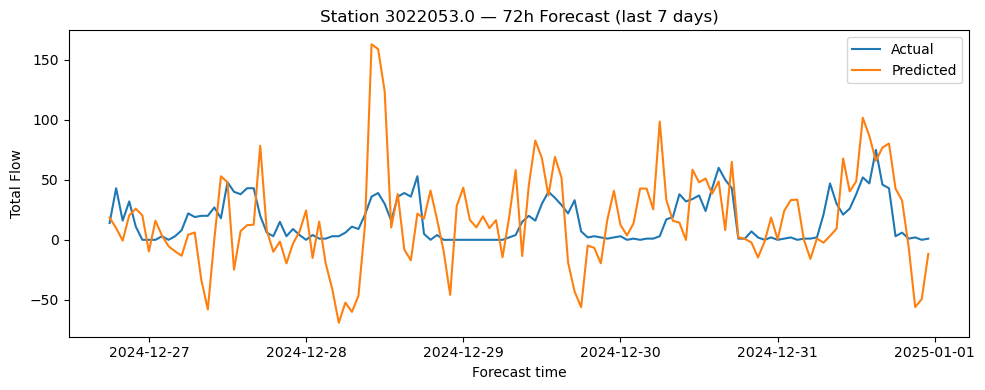

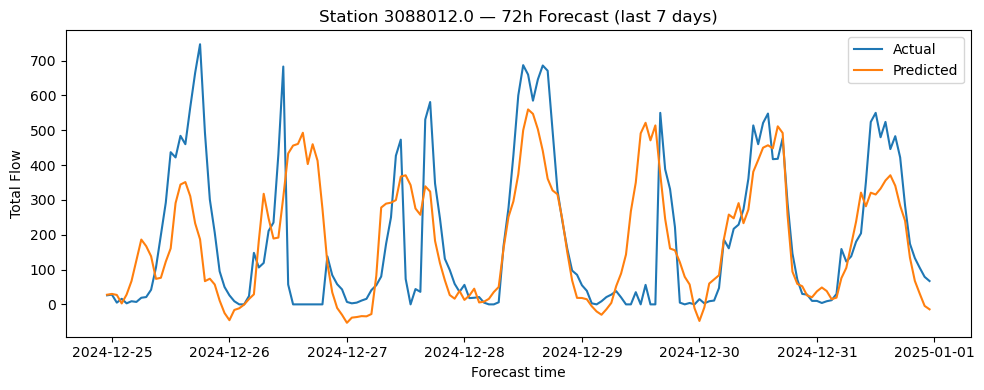

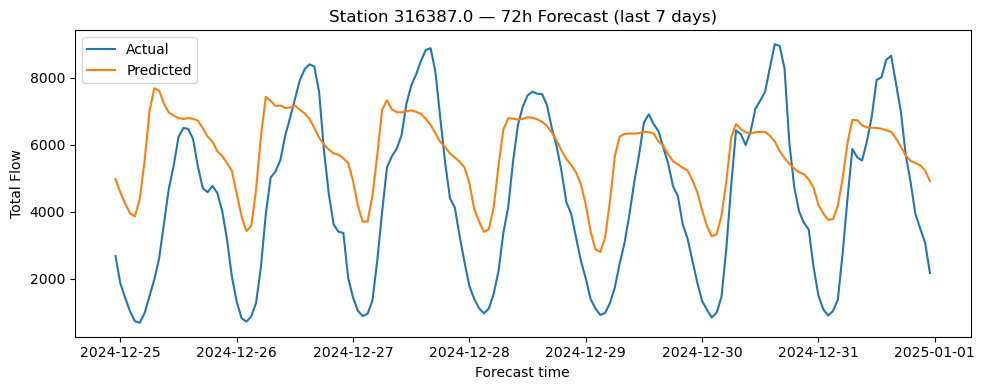

In [23]:
import matplotlib.pyplot as plt

def plot_pred_vs_actual(station_id, days=7, save=True):
    dfp = preds_72h[preds_72h["Station"]==station_id].sort_values("ts_forecast")
    if dfp.empty: 
        print(f"No predictions for station {station_id}"); 
        return
    cut = dfp["ts_forecast"].max() - pd.Timedelta(days=days)
    dfp = dfp[dfp["ts_forecast"]>=cut]

    plt.figure(figsize=(10,4))
    plt.plot(dfp["ts_forecast"], dfp["actual_72h"], label="Actual")
    plt.plot(dfp["ts_forecast"], dfp["pred_72h"],   label="Predicted")
    plt.title(f"Station {station_id} — 72h Forecast (last {days} days)")
    plt.xlabel("Forecast time"); plt.ylabel("Total Flow"); plt.legend(); plt.tight_layout()
    if save:
        plt.savefig(f"fig_72h_pred_vs_actual_station_{station_id}.png", dpi=180)
    plt.show()

for s in stations_to_plot:
    plot_pred_vs_actual(s)


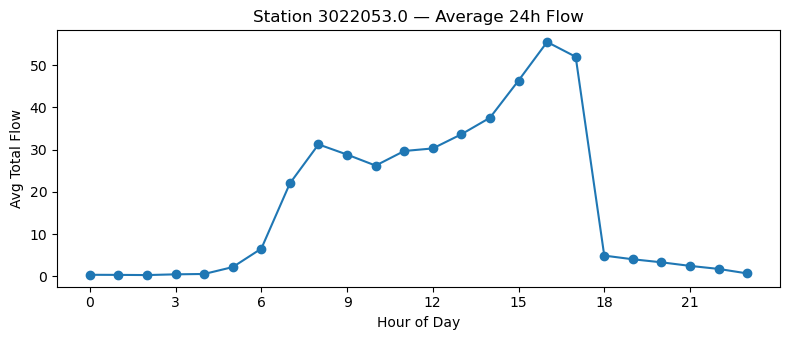

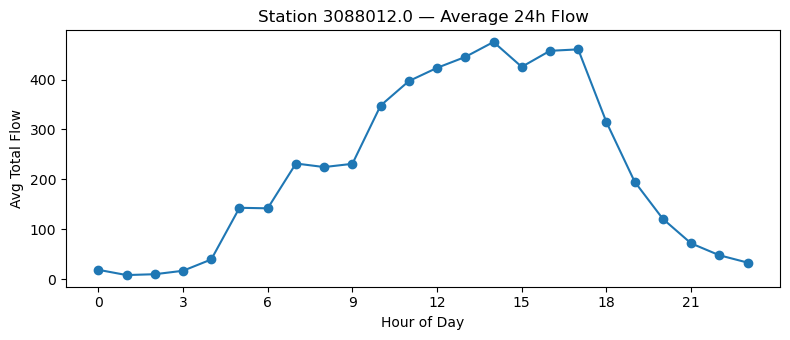

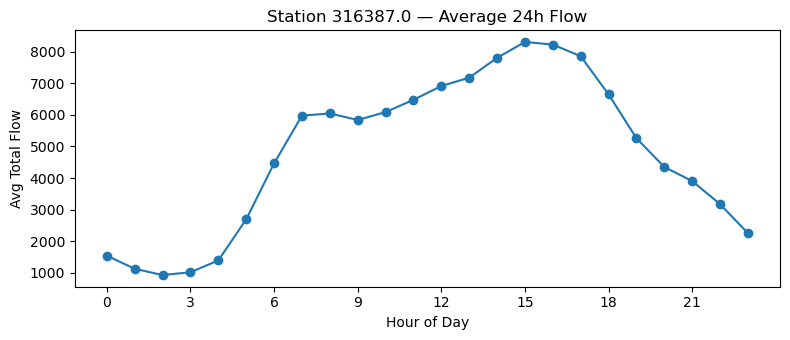

In [24]:
def plot_avg_diurnal(station_id, save=True):
    d = df_model[df_model["Station"]==station_id]
    if d.empty: 
        print(f"No data for station {station_id}"); 
        return
    diurnal = d.groupby(d.index.hour)[BASE_FLOW].mean()

    plt.figure(figsize=(8,3.5))
    plt.plot(diurnal.index, diurnal.values, marker="o")
    plt.title(f"Station {station_id} — Average 24h Flow")
    plt.xlabel("Hour of Day"); plt.ylabel("Avg Total Flow"); plt.xticks(range(0,24,3))
    plt.tight_layout()
    if save:
        plt.savefig(f"fig_avg_diurnal_station_{station_id}.png", dpi=180)
    plt.show()

for s in stations_to_plot:
    plot_avg_diurnal(s)


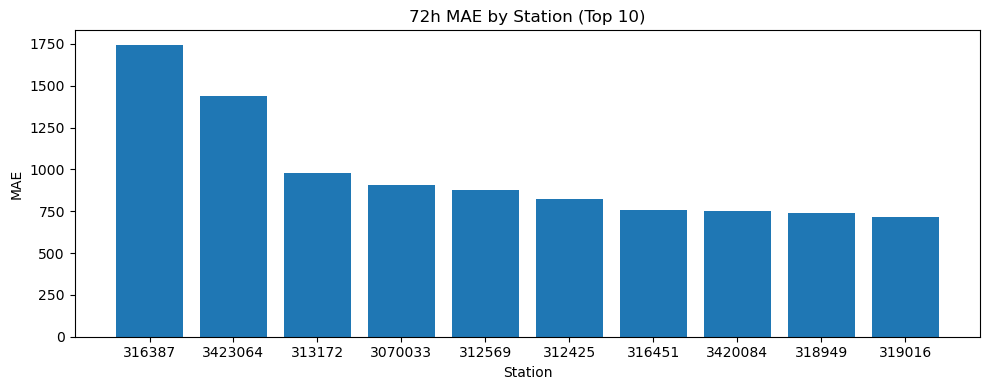

In [25]:
top10 = metrics_72h.sort_values("MAE_72h", ascending=False).head(10)
plt.figure(figsize=(10,4))
plt.bar(top10["Station"].astype(str), top10["MAE_72h"])
plt.title("72h MAE by Station (Top 10)")
plt.xlabel("Station"); plt.ylabel("MAE"); plt.tight_layout()
plt.savefig("fig_72h_mae_by_station_top10.png", dpi=180)
plt.show()


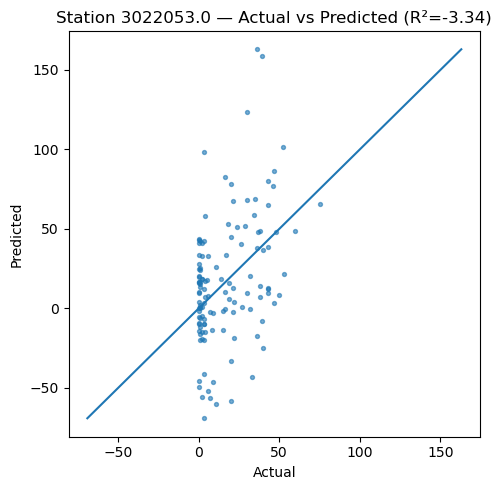

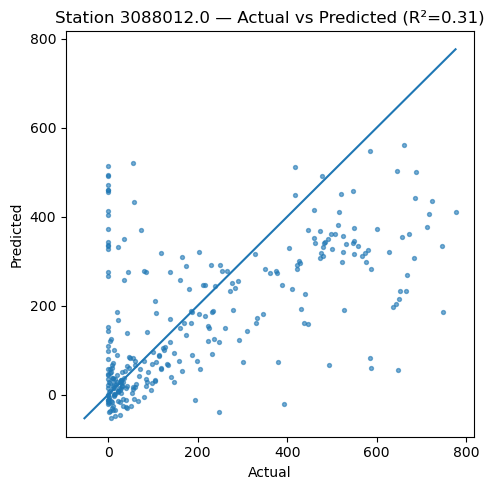

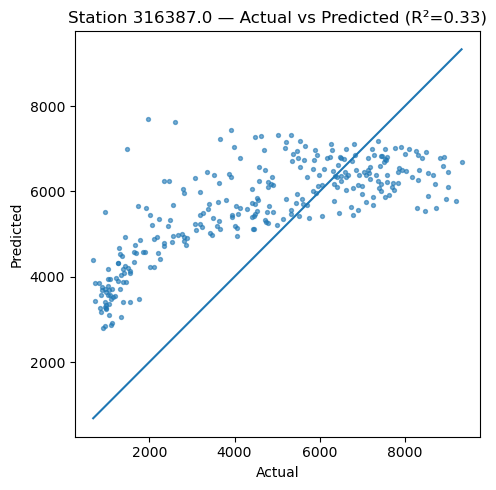

In [26]:
import numpy as np
from sklearn.metrics import r2_score

def plot_scatter_actual_pred(station_id, save=True):
    dfp = preds_72h[preds_72h["Station"]==station_id]
    if dfp.empty: return
    x = dfp["actual_72h"].to_numpy()
    y = dfp["pred_72h"].to_numpy()
    r2 = r2_score(x, y)

    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=8, alpha=0.6)
    mn, mx = np.nanmin(np.r_[x,y]), np.nanmax(np.r_[x,y])
    plt.plot([mn, mx], [mn, mx])
    plt.title(f"Station {station_id} — Actual vs Predicted (R²={r2:.2f})")
    plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.tight_layout()
    if save:
        plt.savefig(f"fig_72h_scatter_station_{station_id}.png", dpi=180)
    plt.show()

for s in stations_to_plot:
    plot_scatter_actual_pred(s)


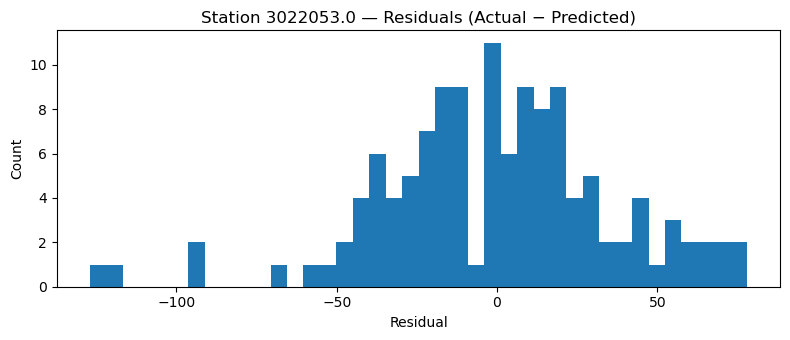

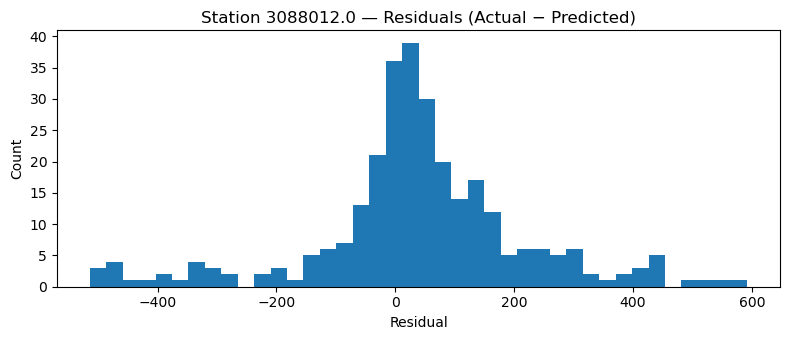

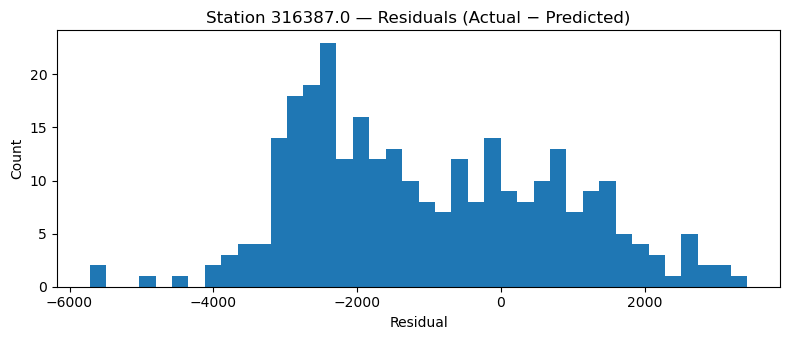

In [27]:
def plot_residual_hist(station_id, save=True):
    dfp = preds_72h[preds_72h["Station"]==station_id]
    if dfp.empty: return
    plt.figure(figsize=(8,3.5))
    plt.hist(dfp["residual"], bins=40)
    plt.title(f"Station {station_id} — Residuals (Actual − Predicted)")
    plt.xlabel("Residual"); plt.ylabel("Count"); plt.tight_layout()
    if save:
        plt.savefig(f"fig_72h_residual_hist_station_{station_id}.png", dpi=180)
    plt.show()

for s in stations_to_plot:
    plot_residual_hist(s)
